In [1]:
!wget https://raw.githubusercontent.com/cbtn-data-science-ml/tensorflow-professional-developer/main/model_utils.py

--2024-11-17 17:25:35--  https://raw.githubusercontent.com/cbtn-data-science-ml/tensorflow-professional-developer/main/model_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2305 (2.3K) [text/plain]
Saving to: ‘model_utils.py’

model_utils.py      100%[===================>]   2.25K  --.-KB/s    in 0s      

2024-11-17 17:25:35 (47.1 MB/s) - ‘model_utils.py’ saved [2305/2305]



In [2]:
from model_utils import plot_loss_and_accuracy, early_stopping_callback, model_checkpoint_callback

In [3]:
# Clone repo
!git clone https://github.com/cbtn-data-science-ml/tensorflow-professional-developer.git

Cloning into 'tensorflow-professional-developer'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 250 (delta 5), reused 11 (delta 3), pack-reused 236 (from 1)
Receiving objects: 100% (250/250), 9.15 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (108/108), done.


| Feature                | `!cd` (Shell Command)       | `%cd` (Magic Command)                  |
|------------------------|-----------------------------|----------------------------------------|
| **Scope**             | Temporary (subshell only)   | Persistent (notebook-wide)            |
| **Effect on Notebook**| No effect on working dir    | Changes notebook's working dir        |
| **Use Case**          | One-off shell commands      | Lasting directory changes             |

In [4]:
# Print working directory !pwd or %pwd?
!pwd

/content


In [5]:
# Change directory
%cd '/content/tensorflow-professional-developer'

/content/tensorflow-professional-developer


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout


In [7]:
train_path = 'nlp_disaster_tweets/train.csv'
test_path = 'nlp_disaster_tweets/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## EDA

In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train_df['text'].tail()

,text
7608,Two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,Police investigating after an e-bike collided ...
7612,The Latest: More Homes Razed by Northern Calif...


In [10]:
# Good idea to shuffle the data
train_df = train_df.sample(frac=1, random_state=42)
test_df = test_df.sample(frac=1, random_state=42)

In [11]:
train_df['text'].tail()

,text
5226,@Eganator2000 There aren't many Obliteration s...
5390,just had a panic attack bc I don't have enough...
860,Omron HEM-712C Automatic Blood Pressure Monito...
7603,Officials say a quarantine is in place at an A...
7270,I moved to England five years ago today. What ...


In [12]:
train_df.target.value_counts() # Is the dataset balanced? close enought to 50/50 IMO
# If imbalanced see: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

,count
target,
0,4342
1,3271


In [13]:
len(train_df), len(test_df)

(7613, 3263)

In [14]:
# Sample 5 random tweets and their classification
random_samples = train_df.sample(n=10, random_state=42)
print(random_samples[['text', 'target']])

                                                   text  target
4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
584   FedEx no longer to transport bioterror germs i...       0
7411  Gunmen kill four in El Salvador bus attack: Su...       1
5950  @camilacabello97 Internally and externally scr...       1
5541  Radiation emergency #preparedness starts with ...       1
6358  Investigators rule catastrophic structural fai...       1
59    How the West was burned: Thousands of wildfire...       1
7018  Map: Typhoon Soudelor's predicted path as it a...       1
455   Ûª93 blasts accused Yeda Yakub dies in Karach...       1
727       My ears are bleeding  https://t.co/k5KnNwugwT       0


In [15]:
# For the training dataset
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 2644 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB
None
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [16]:
# For the test dataset
print(test_df.info())
print(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 3263 entries, 2406 to 3174
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 127.5+ KB
None
                 id
count   3263.000000
mean    5427.152927
std     3146.427221
min        0.000000
25%     2683.000000
50%     5500.000000
75%     8176.000000
max    10875.000000


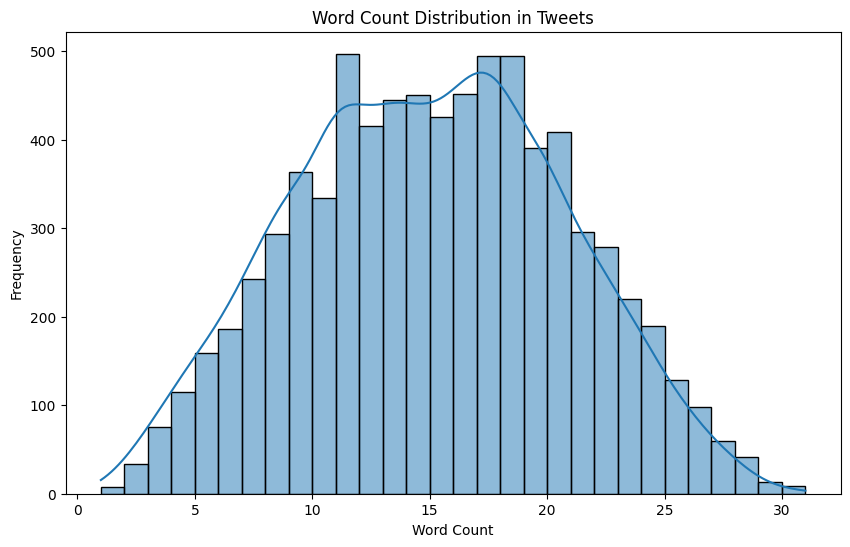

In [17]:
# Calculate word counts for each tweet
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=30, kde=True)
plt.title('Word Count Distribution in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


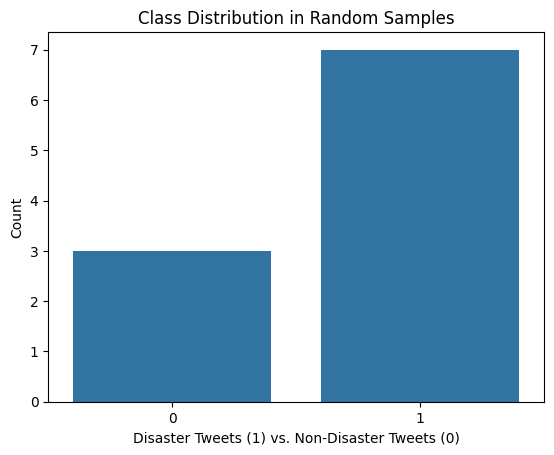

In [18]:
sns.countplot(x='target', data=random_samples)
plt.title('Class Distribution in Random Samples')
plt.xlabel('Disaster Tweets (1) vs. Non-Disaster Tweets (0)')
plt.ylabel('Count')
plt.show()


# Challenge

In [50]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Preprocessing
nltk.download('stopwords') # 'the', 'is', 'in', 'and'

def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'[^a-z\s]', '', text)
  stop_words = set(stopwords.words('english'))
  text = " ".join([word for word in text.split() if word not in stop_words])
  return text

train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text_clean'].astype(str))
max_features = 1000
sequences = tokenizer.texts_to_sequences(train_df['text_clean'].astype(str))

X = pad_sequences(sequences, maxlen=25)
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# Multilayer GRU (Bidirectional)
from tensorflow.keras.layers import GRU, Bidirectional

model_gru = Sequential([
    Embedding(input_dim=max_features, output_dim=64),
    GRU(16, return_sequences=True),
    GRU(8),
    Dense(1, activation='sigmoid')
], name="GRU_Model")

model_gru.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_val, y_val))

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5736 - loss: 0.6884 - val_accuracy: 0.5634 - val_loss: 0.6711
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5829 - loss: 0.6570 - val_accuracy: 0.6422 - val_loss: 0.6337
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7029 - loss: 0.6064 - val_accuracy: 0.7485 - val_loss: 0.5529
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7965 - loss: 0.4928 - val_accuracy: 0.7768 - val_loss: 0.4942
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8181 - loss: 0.4158 - val_accuracy: 0.7886 - val_loss: 0.4859
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8165 - loss: 0.4083 - val_accuracy: 0.7853 - val_loss: 0.4884
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8399 - loss: 0.3743 - val_accuracy: 0.7781 - val_loss: 0.4911
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8346 - loss: 0.3845 - val_accuracy: 0.

In [52]:
# GRU Architecture
model_gru.summary()

Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 25, 64)              │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ (None, 25, 16)              │           3,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,709 (803.55 KB)

 Trainable params: 68,569 (267.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,140 (535.71 KB)

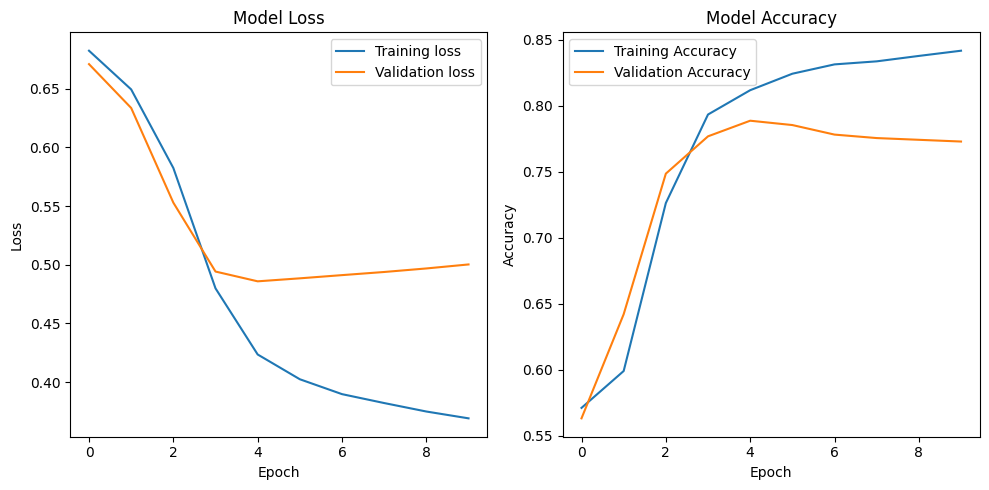

In [53]:
# After training, plot the loss and accuracy
plot_loss_and_accuracy(history_gru)

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dropout


# Convolutional LSTM Model
model_conv_lstm = Sequential([
    Embedding(input_dim=max_features, output_dim=64),  # Embedding layer
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # Conv layer
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional LSTM
    Dense(64, activation='relu'),  # Fully connected Dense layer
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')  # Output  for binary classification
], name="Conv_LSTM_Model")

# Compile the model
model_conv_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_conv_lstm = model_conv_lstm.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_val, y_val))


Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5511 - loss: 0.6865 - val_accuracy: 0.5634 - val_loss: 0.6680
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6485 - loss: 0.6338 - val_accuracy: 0.7656 - val_loss: 0.4961
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8057 - loss: 0.4405 - val_accuracy: 0.7873 - val_loss: 0.4719
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8299 - loss: 0.4085 - val_accuracy: 0.7846 - val_loss: 0.4783
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8402 - loss: 0.3913 - val_accuracy: 0.7925 - val_loss: 0.4824
Epoch 6/10
 50/305 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8459 - loss: 0.3699

In [ ]:
# Conv1D Architecture
model_conv_lstm.summary()

In [ ]:
# After training, plot the loss and accuracy
plot_loss_and_accuracy(history_conv_lstm)